In [1]:
import numpy as np
import tensorflow as tf
import read_dataset as ds
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img,lbl = ds.load_mnist()
print(img.shape)

(17000, 28, 28)


In [3]:
np.random.seed(0)
N,H,W = img.shape
X = np.reshape(img,(N,H*W))
X = X.astype(np.float32)
print(X.shape)
Y = np.zeros((N,10))
for i in range(N):
    Y[i,lbl[i]] = 1

(17000, 784)


In [4]:
img_test,lbl_test = ds.load_mnist(dataset='testing')
N_test,_,_ = img_test.shape
X_test = np.reshape(img_test,(N_test,H*W))
X_test = X_test.astype(np.float32)
print(X_test.shape)
Y_test = np.zeros((N,10))
for i in range(N_test):
    Y_test[i,lbl_test[i]] = 1


(3000, 784)


In [5]:
# Parameters
learning_rate = 0.001
training_iters = 300000
batch_size = 64
display_step = 10

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [11]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = conv_net(x, weights, biases, keep_prob)
#y_ = tf.nn.softmax(pred)
prob_mine = tf.argmax(pred, 1)
logits_mine = tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y)
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [12]:
def get_random_batch(X, Y, batch_size):
    N,_ = X.shape
    indexes = np.random.randint(N,size=batch_size)
    batch_x, batch_y = np.copy(X[indexes]),np.copy(Y[indexes])
    return batch_x, batch_y

In [13]:
X_b, Y_b = get_random_batch(X,Y,2)
print(X_b.shape)
print(Y_b.shape)

(2, 784)
(2, 10)


[[  8330636.     -11737762.      -5040990.     -10039025.      -2121938.
    -618515.6875  -4466813.5      3524141.5     17252242.      -1018084.4375]
 [  1408932.25    -9468640.       5547127.5     11276669.     -12106393.
    3171062.75     5967064.5     -4785688.      41264488.       4330807.    ]] [8 8] 1.0


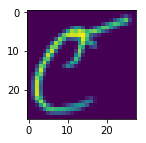

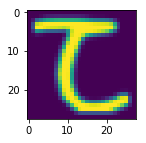

In [15]:
with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step < 100:
        batch_x,batch_y = get_random_batch(X,Y,10)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % 2 == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            '''print("Iter " + str(step*2) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))'''
        step += 1
        #print("Optimization Finished!")
    x_test,y_test = get_random_batch(X_test,Y_test,2)
    probs,prediction_mine,accu_mine = sess.run([pred,tf.argmax(pred,1),accuracy],feed_dict={x: x_test,y:y_test,keep_prob: 1.})
    print(probs,prediction_mine,accu_mine)
    plt.figure(figsize=(2,2))
    plt.imshow(np.reshape(x_test[0],(H,W)))
    plt.figure(figsize=(2,2))
    plt.imshow(np.reshape(x_test[1],(H,W)))

In [ ]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = get_random_batch(X, Y, batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            x_test,y_test = get_random_batch(X_test,Y_test,256)
            print("Testing Accuracy:", \
                                    sess.run(accuracy, feed_dict={x: x_test,
                                      y: y_test,
                                      keep_prob: 1.}))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for 256 mnist test images
    